In [1]:
import torch
import torchvision
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import PIL.ImageOps 

In [2]:
def show_img(img0,title=None):
    img=img0.numpy()
    plt.axis("off")
    if title:
        plt.text(75, 8, text, style='italic',fontweight='bold',bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(img,(1,2,0)))
    plt.show()
                                                                     
def plot_loss(iteration,loss):
    plt.plot(iteration,loss)        
    plt.show()

# 定义dataset和dataloader

In [3]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset=imageFolderDataset
        self.transform=transform
        self.should_invert=should_invert
        
    def __getitem__(self,index):  #获取图片1、图片2、标签
        #锚样本
        img1_folder=random.choice(self.imageFolderDataset.imgs)
        #正例
        while True:
            img2_folder=random.choice(self.imageFolderDataset.imgs)
            if img1_folder[1]==img2_folder[1]:
                break
        #负例
        while True:
            img3_folder=random.choice(self.imageFolderDataset.imgs)
            if img1_folder[1]!=img3_folder[1]:
                break
                    
        #装换成灰度图            
        img1=Image.open(img1_folder[0])
        img2=Image.open(img2_folder[0])
        img3=Image.open(img3_folder[0])

        img1=img1.convert('L')
        img2=img2.convert('L')
        img3=img3.convert('L')

        
        if self.should_invert:
            img1=Image.ImageOps.invert(img1)
            img2=Image.ImageOps.invert(img2) 
            img3=Image.ImageOps.invert(img3) 

            
        if self.transform is not None:
            img1=self.transform(img1)
            img2=self.transform(img2) 
            img3=self.transform(img3)  
                               
        return img1,img2,img3
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)
    
#定义训练集地址
train_dir='D:/数据库/palmdata/tju1'
batch_size=5

folder_dataset = torchvision.datasets.ImageFolder(root=train_dir)

transform=transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])

siamese_dataset=SiameseNetworkDataset(imageFolderDataset=folder_dataset,transform=transform,should_invert=False)

train_dataloader=DataLoader(siamese_dataset,shuffle=True,batch_size=batch_size)

#定义测试集
test_dir='D:/数据库/palmdata/tju2'

folder_dataset1 = torchvision.datasets.ImageFolder(root=test_dir)

siamese_dataset1=SiameseNetworkDataset(imageFolderDataset=folder_dataset1,transform=transform,should_invert=False)

test_dataloader=DataLoader(siamese_dataset1,shuffle=True,batch_size=batch_size)

# 可视化几个训练图片

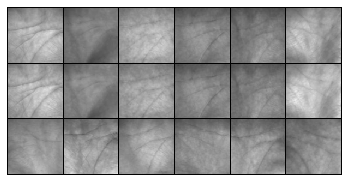

In [4]:
visual_dataloader=DataLoader(siamese_dataset,shuffle=True,batch_size=6)
x1,x2,x3=next(iter(visual_dataloader))
concatenated = torch.cat((x1,x2,x3),0) 
show_img(torchvision.utils.make_grid(concatenated, nrow=6))

# 构建模型

In [5]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn=nn.Sequential(
            nn.ReflectionPad2d(1),   #padding
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
        )
        self.fc=nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5)
        )
    def output(self,x):
        output=self.cnn(x)
        output=output.view(output.size()[0],-1)
        output=self.fc(output)
        return output
    def forward(self,x1,x2,x3):
        output1=self.output(x1)
        output2=self.output(x2) 
        output3=self.output(x3) 

        return output1,output2,output3

# 训练模型

Epoch number: 0 , Current loss: 0.4278

Epoch number: 1 , Current loss: 0.0000

Epoch number: 2 , Current loss: 0.0000

Epoch number: 3 , Current loss: 0.0000

Epoch number: 4 , Current loss: 0.0000



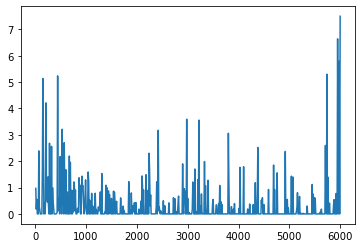

In [6]:
net = SiameseNetwork().cuda() #定义模型且移至GPU
criterion = nn.TripletMarginLoss(margin=1.0, p=2) #定义损失函数
optimizer = optim.Adam(net.parameters(), lr = 0.0005) #定义优化器

epochs=5
counter = []
loss_history = [] 
iteration_number = 0


#开始训练
for epoch in range(0, epochs):
    for i, data in enumerate(train_dataloader, 0):
        img1, img2 , img3 = data
        #img0维度为torch.Size([32, 1, 100, 100])，32是batch，label为torch.Size([32, 1])
        img1, img2 , img3 = img1.cuda(), img2.cuda(), img3.cuda() #数据移至GPU
        optimizer.zero_grad()
        output1,output2,output3 = net(img1, img2,img3)
        loss_triplet = criterion(output1, output2, output3)
        loss_triplet.backward()
        optimizer.step()
        if i % 10 == 0 :
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_triplet.item())
    print("Epoch number: {} , Current loss: {:.4f}\n".format(epoch,loss_triplet.item()))

plot_loss(counter, loss_history)

# 测试模型

In [7]:
losses=[]
for i, data in enumerate(test_dataloader, 0):
    img1, img2 ,img3 = data
    #img0维度为torch.Size([32, 1, 100, 100])，32是batch，label为torch.Size([32, 1])
    img1, img2 , img3 = img1.cuda(), img2.cuda(), img3.cuda() #数据移至GPU
    output1,output2,output3=net(img1,img2,img3)
    loss_ = criterion(output1,output2,output3)
    if i % 10 == 0 :
            losses.append(loss_.item())
print(sum(losses)/len(losses))

0.4702735639332483


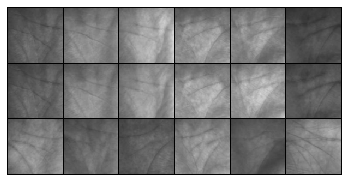

pre
torch.Size([6, 1, 100, 100])
torch.Size([6, 5])
p: tensor(0.8247, device='cuda:0', grad_fn=<DivBackward0>)
n: tensor(4.0469, device='cuda:0', grad_fn=<DivBackward0>)
p: tensor(0.4649, device='cuda:0', grad_fn=<DivBackward0>)
n: tensor(4.6023, device='cuda:0', grad_fn=<DivBackward0>)
p: tensor(0.5587, device='cuda:0', grad_fn=<DivBackward0>)
n: tensor(7.3701, device='cuda:0', grad_fn=<DivBackward0>)
p: tensor(2.9204, device='cuda:0', grad_fn=<DivBackward0>)
n: tensor(3.2242, device='cuda:0', grad_fn=<DivBackward0>)
p: tensor(0.6698, device='cuda:0', grad_fn=<DivBackward0>)
n: tensor(5.3312, device='cuda:0', grad_fn=<DivBackward0>)
p: tensor(1.1250, device='cuda:0', grad_fn=<DivBackward0>)
n: tensor(9.5672, device='cuda:0', grad_fn=<DivBackward0>)


In [8]:
test_dataloader=DataLoader(siamese_dataset,shuffle=True,batch_size=6)
x1,x2,x3=next(iter(test_dataloader))
concatenated = torch.cat((x1,x2,x3),0) 
show_img(torchvision.utils.make_grid(concatenated, nrow=6))

      
print('pre')
x1,x2,x3=x1.cuda(),x2.cuda(),x3.cuda()
print(x1.shape)
out1,out2,out3 = net.forward(x1,x2,x3)
print(out1.shape)
# oushi1=torch.dist(out1, out2, p=2)
# oushi2=torch.dist(out1, out3, p=2)
oushi1=torch.sqrt(((out1-out2)**2))
oushi2=torch.sqrt(((out1-out3)**2))

for i in range(6):
    d1=sum(oushi1[i])/5
    d2=sum(oushi2[i])/5
    print('p:',d1)
    print('n:',d2)    

# N way 1 shot任务测试

In [9]:
import os
#返回一个img_items列表，包含所有图片样本，每个样本都是一个三元组（图片名词，语言/字母类别，图片样本所在的目录）

def read_img(img_path):
    inp=np.array(Image.open(img_path).resize((105,105)))
    return inp

data_path='D:/数据库/palmdata/tju1/'
img_items = []
files = os.listdir(data_path)
files=list(map(int,files))
files.sort()
files=list(map(str,files))
#print(files)
total_images=[]
for file in files:  #1~600
    f_images=[]
    images=os.listdir(os.path.join(data_path,file))
    for i in range(1,len(images)): #1~10
        image_path=os.path.join(data_path,file,str(i)+'.jpeg')
        image=read_img(image_path)
        f_images.append(image)
    total_images.append(f_images)
total_images=np.array(total_images)
print(total_images.shape)

(460, 5, 105, 105)


In [16]:
import numpy.random as rng
from sklearn.utils import shuffle


#为测试集生成 N-way one-shot 任务
def make_oneshot_task(N):
    X=torch.from_numpy(total_images)
    n_classes, n_examples, w, h = X.shape
    indices = rng.randint(0,n_examples,size=(N,))  #从0~n_examples随机选择一个样本，重复N次
        
    #选择N个类的样本
    categories = rng.choice(range(n_classes),size=(N,),replace=False)       
    #support集为N类，每类随机取出一张图片。test_image为N张support集中第一类别的某张图片。
    #support集每张图片都分别与test_image组对，targets存放每一对是否同类的标签。targets=[1,0,0,,,0,0,0,0,0]    
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))  #从n_examples中随机选择两个样本，分别代表第一对的两个样本
    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)  #测试图片集为N张第一类别的某个图片
        
    support_set = X[categories,indices,:,:]  #从N个类中分别随机选择一个样本组成support集，一共N*1个样本
    support_set[0,:,:] = X[true_category,ex2] 
    support_set = support_set.reshape(N, w, h,1)
        
    targets = np.zeros((N,))
    targets[0] = 1 #仅第一对是同类，其他不同类
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]   

    return pairs, targets
    
#在测试我们的孪生网络模型在N way 1 shot上准确率，重复k次，求平均准确率
def test_oneshot(model,N,k,verbose=0):
    n_correct = 0 #记录K way 1 shot任务上预测准确的对数
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ...".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N)  #生成N way 1 shot任务的数据对
        out1 = model.output(inputs[0])  #预测结果
        out2 = model.output(inputs[1])  #预测结果

        oushi=torch.sqrt(((out1-out2)**2))
        dd=[]
        for i in range(len(oushi)):
            d=sum(oushi[i])/5
            dd.append(d)
        if np.argmin(dd)==0:
            n_correct=n_correct+1
    percent_correct = (100.0*n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct,N))
    return percent_correct


test_oneshot(net,20,5,0)

ValueError: only one element tensors can be converted to Python scalars